In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './preprocess_data/data/'
# DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [3]:
# x_train_dir = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'trainannot')

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

x_train_dir = os.path.join(DATA_DIR, 'train_images_all')
y_train_dir = os.path.join(DATA_DIR, 'train_images_all')

x_valid_dir = os.path.join(DATA_DIR, 'train_images_all')
y_valid_dir = os.path.join(DATA_DIR, 'train_images_all')

x_test_dir = os.path.join(DATA_DIR, 'train_images_all')
y_test_dir = os.path.join(DATA_DIR, 'train_images_all')

In [4]:
# # helper function for data visualization
# def visualize(**images):
#     """PLot images in one row."""
#     n = len(images)
#     plt.figure(figsize=(16, 5))
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         plt.imshow(image)
#     plt.show()

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [6]:
ALLOWED_EXTENSIONS = ['jpg','JPG','jpeg','JPEG','png','PNG']
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

In [7]:
n_classes = 47

In [8]:
class Dataset(BaseDataset):

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [filename for filename in os.listdir(images_dir) if allowed_file(filename)]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0] + '.npy') for image_id in self.ids]
        

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.cvtColor(cv2.imread(self.images_fps[i]), 1)
        mask = np.expand_dims(np.load(self.masks_fps[i]), axis=2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [9]:
# Lets look at data we have


dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[1] # get some sample

In [10]:
dataset[8][0].shape

(384, 480, 3)

In [11]:
dataset[8][1].shape

(384, 480, 1)

In [12]:
import pandas as pd
pd.Series(dataset[8][1].flatten()).unique()

array([ 0, 35,  2, 34,  7], dtype=uint8)

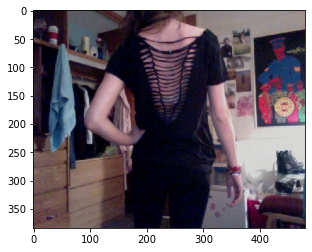

In [13]:
plt.imshow(image)

In [14]:
mask.shape

(384, 480, 1)

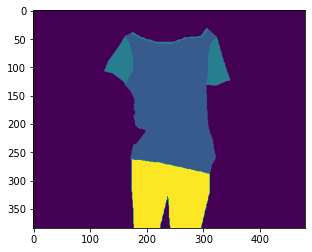

In [15]:
plt.imshow(mask)

In [16]:
import albumentations as albu

In [17]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [18]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [19]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['car']
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
ACTIVATION = 'softmax'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [20]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [21]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [22]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [23]:
# train model for 40 epochs

max_score = 0

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/5649 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


train:   1%|▏         | 83/5649 [00:35<39:43,  2.34it/s, dice_loss - -0.3575, iou_score - 0.0002585] 


KeyboardInterrupt: 

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=4,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=4,
)

In [ ]:
n = np.random.choice(len(test_dataset))
    
# image_vis, gt_mask = test_dataset_vis[n][0].astype('uint8'), test_dataset_vis[n][1]
# image = test_dataset[n][0]

image_vis = test_dataset_vis[n][0].astype('uint8')
image, gt_mask = test_dataset[n]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)

test_prediction1 = np.argmax(pr_mask.squeeze().cpu().numpy(), axis=0)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image_vis[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.expand_dims(gt_mask, axis=2)[:,:,0].astype(int))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [ ]:
pd.Series(np.expand_dims(gt_mask, axis=2)[:,:,0].astype(int).flatten()).unique()

In [ ]:
pd.Series(np.expand_dims(test_prediction1, axis=2)[:,:,0].astype(int).flatten()).unique()

In [ ]:
np.expand_dims(test_prediction1, axis=2)[:,:,0].astype(int).shape

In [ ]:
np.expand_dims(gt_mask, axis=2)[:,:,0].astype(int).shape